# Data project

**Variables** 

Udlån 

Materialeudgifter (1.000 kr.)

Imports and Magic settings 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

import datetime

import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from pandasql import sqldf

**Importing data**

**Importing data for libraries from DST.** 

In [2]:
#Object for interacting with DST 
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'


#Values of the variables  
bib_vars  = Dst.get_variables(table_id = 'BIB1')

for id in [ 'BNØGLE', 'Tid']:
    print(id)
    values = bib_vars.loc[bib_vars.id ==id, ['values']].values[0,0]
    for value in values:
        print(f'id = {value["id"]}, text = {value["text"]}')

BNØGLE
id = 15110, text = Loan. All materials
id = 15120, text = Loan. Books
id = 15130, text = Loan. Audio books
id = 15140, text = Loan. Music recordings
id = 15150, text = Loan. Moving pictures
id = 15160, text = Loan. Multimedia
id = 15170, text = Loan. Other materials
id = 15175, text = Loan. Serial publications
id = 15180, text = Stock. All materials
id = 15190, text = Stock. Books
id = 15200, text = Stock. Audio books
id = 15210, text = Stock. Music recordings
id = 15220, text = Stock. Moving pictures
id = 15230, text = Stock. Multimedia
id = 15240, text = Stock. Other materials
id = 15245, text = Stock. Serial publications (subscribers)
id = 15250, text = Uses of electronic ressources (downloads)
id = 15260, text = Expenditure, materials (DKK 1,000)
Tid
id = 2009, text = 2009
id = 2010, text = 2010
id = 2011, text = 2011
id = 2012, text = 2012
id = 2013, text = 2013
id = 2014, text = 2014
id = 2015, text = 2015
id = 2018, text = 2018
id = 2019, text = 2019
id = 2020, text = 202

In [5]:
#Object for interacting with DST 
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'

#Dictionary of variables of the disired data  (Loan. All materials)
var_loan = {'OMRÅDE': ['*'], 'BNØGLE': [ '15120' ], 'Tid': ['*']}
var_exp = {'OMRÅDE': ['*'], 'BNØGLE': [ '15260'], 'Tid': ['*']}

#Raw dataset 
bib_api_loan = Dst.get_data(table_id = 'BIB1', variables = var_loan)
bib_api_exp = Dst.get_data(table_id = 'BIB1', variables = var_exp)

bib_api_loan.rename     (columns={'INDHOLD': 'loan', 'BNØGLE' : 'slet_var' }, inplace=True)
bib_api_exp.rename      (columns={'INDHOLD': 'exp', 'BNØGLE' : 'slet_var2'}, inplace=True)



bib_api = bib_api_loan.merge(bib_api_exp, on=['OMRÅDE', 'TID'])
bib_api.head()


,OMRÅDE,slet_var,TID,loan,slet_var2,exp
0,All Denmark,Loan. Books,2009,32256695,"Expenditure, materials (DKK 1,000)",387005
1,Region Nordjylland,Loan. Books,2009,3137993,"Expenditure, materials (DKK 1,000)",32779
2,Region Midtjylland,Loan. Books,2009,7021388,"Expenditure, materials (DKK 1,000)",73523
3,Region Syddanmark,Loan. Books,2009,6795849,"Expenditure, materials (DKK 1,000)",85267
4,Region Hovedstaden,Loan. Books,2009,10641050,"Expenditure, materials (DKK 1,000)",136883


**Importing data for population by munisipality** 

In [6]:
#Loading the data 
var_pick = {'OMRÅDE': ['*'], 'Tid':['*']}
bef_api = Dst.get_data(table_id='FOLK1A', variables=var_pick)
bef_api.sort_values(by=['OMRÅDE'], inplace=True)

# Keeping only the 1 quarter 
I = bef_api['TID'].str.endswith('Q1')
bef_api_q1 = bef_api[I]

#Renaming the time variable such that it does not include the quarter 
bef_api_q1 = bef_api_q1.rename(columns={'TID': 'tid_temp'})
bef_api_q1['tid_temp'] = bef_api_q1['tid_temp'].str.slice(stop=4)
bef_api_q1 = bef_api_q1.rename(columns={'tid_temp': 'TID'})

#Variable TID must be an object for merging 
bib_api['TID'] = bib_api['TID'].astype('object')

bef_api_q1.head()

,OMRÅDE,TID,KØN,ALDER,CIVILSTAND,INDHOLD
3452,Aabenraa,2013,Total,Total,Total,59208
3157,Aabenraa,2015,Total,Total,Total,58904
3767,Aabenraa,2011,Total,Total,Total,59795
870,Aabenraa,2022,Total,Total,Total,58693
2465,Aabenraa,2023,Total,Total,Total,59002


**Merging dataset**

Comparing datasets

In [7]:
#The datasets
print(f'Library dataset contains data from: {np.min(bib_api.TID.unique())} to {np.max(bib_api.TID)}')
print(f'Municipalities in Library data = {len(bib_api.OMRÅDE.unique())}')

print(f'Bef dataset contains data from: {np.min(bef_api_q1.TID.unique())} to {np.max(bef_api_q1.TID)}')
print(f'Municipalities in Library data = {len(bef_api_q1.OMRÅDE.unique())}')

#Differenses in the datasets
diff_mun = [m for m in bef_api_q1.OMRÅDE.unique() if m not in bib_api.OMRÅDE.unique()]
print (f' Munisipalities in bef and not in Lib: {diff_mun}')


Library dataset contains data from: 2009 to 2021
Municipalities in Library data = 103
Bef dataset contains data from: 2008 to 2023
Municipalities in Library data = 105
 Munisipalities in bef and not in Lib: ['Christiansø', 'Fanø']


In [8]:
bib_api['TID'] = bib_api['TID'].astype('object')
bib_api['exp'] = bib_api['exp'].astype('int64')
bib_api['loan'] = bib_api['loan'].astype('int64')
bib_api.head()


print(bef_api_q1.dtypes)
print(bib_api.dtypes)

OMRÅDE        object
TID           object
KØN           object
ALDER         object
CIVILSTAND    object
INDHOLD        int64
dtype: object
OMRÅDE       object
slet_var     object
TID          object
loan          int64
slet_var2    object
exp           int64
dtype: object


In [26]:
q = """
SELECT 
bef.OMRÅDE      as mun, 
bef.TID         as year, 
bef.INDHOLD     as n, 
bib.loan, 
bib.exp

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
ORDER BY mun, year
"""

# Apply query using pandasql
df = sqldf(q)
df.head()


df['loan_per_cap'] = df['loan']/df['n']
df['exp_per_cap'] = 1000* df['exp']/df['n']
df.head()

,mun,year,n,loan,exp,loan_per_cap,exp_per_cap
0,Aabenraa,2009,60392,314800,4278,5.212611,70.837197
1,Aabenraa,2010,59978,298039,3994,4.969139,66.591083
2,Aabenraa,2011,59795,289801,3699,4.846576,61.861360
3,Aabenraa,2012,59600,268604,3457,4.506779,58.003356
4,Aabenraa,2013,59208,258318,3429,4.362890,57.914471


**Plot over tid**

/var/folders/1t/shy39gf516g7nrfy2pmdkn780000gn/T/ipykernel_19807/3229831939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['year'] = pd.to_numeric(subset_df['year'])


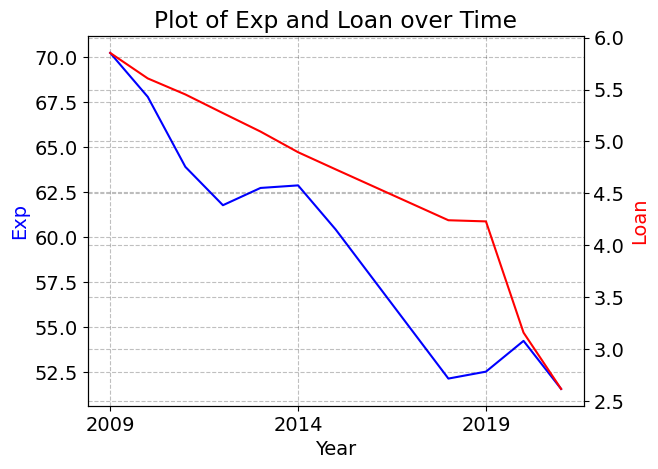

In [33]:
subset_df = df[df['mun'] == 'All Denmark']

# convert 'year' to numeric data type
subset_df['year'] = pd.to_numeric(subset_df['year'])

fig, ax1 = plt.subplots()

# plot 'exp' on the first axis
ax1.plot(subset_df['year'], subset_df['exp_per_cap'], color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Exp', color='b')

# create a twin axis
ax2 = ax1.twinx()

# plot 'loan' on the second axis
ax2.plot(subset_df['year'], subset_df['loan_per_cap'], color='r')
ax2.set_ylabel('Loan', color='r')

# set tick locations and labels for x-axis
xticks = np.arange(subset_df['year'].min(), subset_df['year'].max()+1, 5)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks)

plt.title('Plot of Exp and Loan over Time')
plt.show()


**Scatter plot**

In [38]:
max = df[df['exp_per_cap'].max()]

KeyError: 173.71120726710032

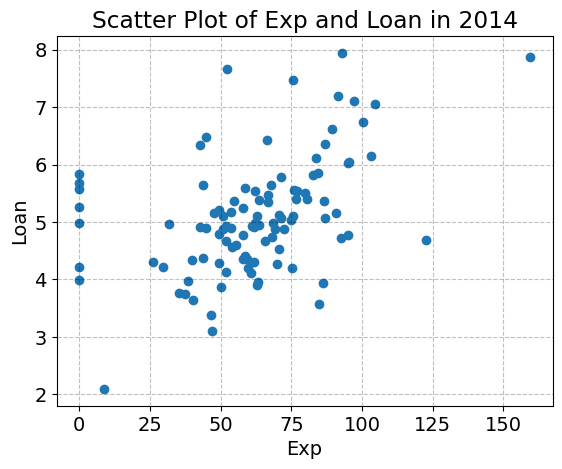

,mun,year,n,loan,exp,loan_per_cap,exp_per_cap
0,Aabenraa,2009,60392,314800,4278,5.212611,70.837197
1,Aabenraa,2010,59978,298039,3994,4.969139,66.591083
2,Aabenraa,2011,59795,289801,3699,4.846576,61.861360
3,Aabenraa,2012,59600,268604,3457,4.506779,58.003356
4,Aabenraa,2013,59208,258318,3429,4.362890,57.914471


In [43]:
# subset the DataFrame where year is equal to 2014
subset_df = df[df['year'] == '2013']

# create a scatter plot with 'exp' on the x-axis and 'loan' on the y-axis
plt.scatter(subset_df['exp_per_cap'], subset_df['loan_per_cap'])

# set plot title and labels
plt.title('Scatter Plot of Exp and Loan in 2014')
plt.xlabel('Exp')
plt.ylabel('Loan')

# display the plot
plt.show()

df.head()


# Stop Her

In [ ]:
q = """
SELECT *
FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""

# Apply query using pandasql
df = sqldf(q)
df.head()



In [ ]:
q = """
SELECT 
bef.OMRÅDE      as mun, 
bef.TID         as year, 
bef.INDHOLD     as n, 
bib.loan, 
bib.exp

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
ORDER BY mun, year
"""

# Apply query using pandasql
df = sqldf(q)
df.head()


df['loan_per_cap'] = df['loan']/df['n']
df['exp_per_cap'] = 1000* df['exp']/df['n']
df.head()


In [ ]:
df['loan_per_cap'] = df['loan']/df['n']
df['exp_per_cap'] = 1000* df['exp']/df['n']
df.head()

In [ ]:
exp = df['exp_per_cap'] 
# a. create the figure
fig = plt.figure()

# b. plot
ax = fig.add_subplot(1,1,1)

ax.plot(exp)

In [ ]:
df = bib_api.merge(bef_api_q1, on=['OMRÅDE', 'TID'])

In [ ]:
df.head()

Merging using SQL

In [ ]:
case 
    when bib.BNØGLE = 'Loan. Books' then bib.INDHOLD                            = 'loan'
    when bib.BNØGLE = 'Expenditure, materials (DKK 1,000)' then bib.INDHOLD     = 'Expenditure'
end as var_navn,

In [ ]:
q = """
SELECT bef.OMRÅDE, bef.TID, bef.INDHOLD as n, bib.INDHOLD as n_bib, bib.BNØGLE 
FROM bef_api_q1 as bef
INNER JOIN bib_api_loan as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""

# Apply query using pandasql
df = sqldf(q)
df.head()

In [ ]:
# Use logical indexing to subset from variable name based on id
#X.loc[X['id'] > 1, ['name']]

bib_api.loc[bib_api['BNØGLE'] == ['BNØGLE']]

In [ ]:
#bef.INDHOLD as n, 
I = bib_api['BNØGLE'] == 'Loan. Books'

bib_api_loan = bib_api[I]

bib_api_loan.head()

#I = bib_api['BNØGLE'] == 'Expenditure, materials (DKK 1,000)' 
#bib_api_exp = bib_api[I]


#bib_api_loan.INDHOLD = loan_n
#INNER JOIN bib_api_loan as bib

In [ ]:
q = """
SELECT bef.OMRÅDE, bef.TID, bef.INDHOLD as n, bib.INDHOLD as n_bib, bib.BNØGLE as test
FROM bef_api_q1 as bef
INNER JOIN bib_api_loan as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""

# Apply query using pandasql
df = sqldf(q)
df.head()

In [ ]:
q = """
SELECT df.OMRÅDE, df.TID, df.n, df.n_bib
FROM df as df
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""

# Apply query using pandasql
df = sqldf(q)
df.head()

In [ ]:
q = """
SELECT bef.OMRÅDE as municipality, bef.TID as year, bef.INDHOLD as n, bib.INDHOLD as n_bib
FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
Where bib.BNØGLE == 'Loan. Books'
"""

# Apply query using pandasql
df = sqldf(q)
df.head()

z = """
SELECT 
df.municipality, 
df.year, 
df.n, 
df.n_bib,  

bib.INDHOLD as n_exp,
bib.BNØGLE  as skal_vaere_exp


FROM df as df
INNER JOIN bib_api as bib
ON bib.OMRÅDE = df.municipality AND bib.TID = df.year
Where bib.BNØGLE == 'Expenditure, materials (DKK 1,000)' 
"""

df_2 = sqldf(z)

df.head()
#df_2.head()

In [ ]:
I = bib_api['BNØGLE'] == 'Loan. Books'
bib_api_loan = bib_api[I]

q = """
SELECT bef.OMRÅDE as municipality, 
bef.TID as year, 
bef.INDHOLD as n, 

bib_api_loan.INDHOLD as loan 

FROM bef_api_q1 as bef

INNER JOIN bib_api_loan as bib_loan
ON bib_loan.OMRÅDE = bef.OMRÅDE and bef.TID = bib_api_loan.TID


"""

# Apply query using pandasql
df = sqldf(q)
df.head()


In [ ]:
I = bib_api['BNØGLE'] == 'Loan. Books'
bib_api_loan = bib_api[I]

q = """
SELECT bef.OMRÅDE as municipality, 
bef.TID as year, 
bef.INDHOLD as n, 

bib_api_loan.INDHOLD as loan, 
bib_api_exp.INDHOLD as exp 

FROM bef_api_q1 as bef

INNER JOIN bib_api_loan as bib_loan
ON bib_loan.OMRÅDE = bef.OMRÅDE and bef.TID = bib_api_loan.TID

INNER JOIN bib_api_exp as bib_exp
ON bib_api_exp.OMRÅDE = bef.OMRÅDE and bef.TID = bib_api_exp.TID

"""

# Apply query using pandasql
df = sqldf(q)
df.head()


In [ ]:
bib_api.head()

In [ ]:
q = """
SELECT 
bef.OMRÅDE, 
bef.TID, 
bef.INDHOLD as n, 
bib.INDHOLD as exp

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
where bib.BNØGLE = 'Loan. Books'
"""

# Apply query using pandasql
df = sqldf(q)

print(f'Merged dataset contains data from: {np.min(df.TID.unique())} to {np.max(bef_api_q1.TID)}')
print(f'Merged dataset contains data form Municipalities = {len(df.OMRÅDE.unique())}')
print(f'Merged dataset contains data form Municipalities = {len(df.OMRÅDE.BNØGLE())}')


df.head()


In [ ]:
q = """
SELECT 
bef.OMRÅDE, 
bef.TID, 
bef.INDHOLD as n, 
case 
    when bib.BNØGLE = 'Loan. Books' then 'loan'
    when bib.BNØGLE = 'Expenditure, materials (DKK 1,000)' then 'Expenditure'
end as var_navn

FROM bef_api_q1 as bef
INNER JOIN bib_api as bib
ON bib.OMRÅDE = bef.OMRÅDE AND bib.TID = bef.TID
"""
# Apply query using pandasql
df = sqldf(q)

In [ ]:
df.head()